<a href="https://colab.research.google.com/github/kyleco/decision/blob/master/negi_wooldridge_covariates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import progressbar
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def population(coefset , N, p_treat):
  K1 = np.random.normal(scale=2, size=N)
  K2 = np.random.normal(scale=2, size=N)
  V = np.random.normal(scale=1, size=N)
  V1 = np.random.normal(scale=1, size=N)

  X1 = K1 + V
  X2 = ((K2 + V / 2) > 0).astype('float')

  G = 1 + np.random.binomial(n=1, p=p_treat, size=N)
  R1 = np.random.normal(scale=1, size=N)
  R2 = (3 / (2 ** 0.5)) * (R1 + V1)

  gamma1 = coefset[1]
  gamma2 = coefset[2]
  Y1 = gamma1[0]  + gamma1[1] * X1 +  gamma1[2] * X2 + gamma1[3] * X1 * X2 + R1
  Y2 = gamma2[0]  + gamma2[1] * X1 +  gamma2[2] * X2 + gamma2[3] * X1 * X2 + R2

  Y = Y1 * (G==1) + Y2 * (G==2)

  df = pd.DataFrame({'y': Y, 'x1': X1, 'x2': X2, 'x1x2': X1 * X2, 'g': G})
  return df

In [53]:

# Simple difference in means
def sm(df):
  return df.groupby('g')['y'].mean().diff()[2]


# Full regression adjustment
def fra(df):
  x1dot = df.x1 - df.x1.mean()
  x2dot = df.x2 - df.x2.mean()
  x1x2dot = df.x1x2 - (df.x1x2).mean()
  r = smf.ols("y ~ I(g==2) + x1 + x2 + x1x2 + I(g==2):(x1dot + x2dot + x1x2dot)", df).fit()
  return r.params['I(g == 2)[T.True]']

# Alternative implementation equivalent to fra
# def sra(df):
#   r1 = smf.ols("y ~ x1 + x2 + x1:x2", df.query("g==1")).fit()
#   r2 = smf.ols("y ~ x1 + x2 + x1:x2", df.query("g==2")).fit()
#   return r2.predict(df).mean() - r1.predict(df).mean()

# Pooled regression adjustment
def pra(df):
  r = smf.ols("y ~ I(g==2) + x1 + x2 + x1x2", df).fit()
  return r.params['I(g == 2)[T.True]']


# CUPED (adapted for multiple covariates)
# "The optimal θ turns out to be the ordinary least square (OLS) solution of regressing (centered) Y on (centered) X, "
# https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf 
def cuped(df):
  # Regression based on pooled data. For convenience, not demeaning. Including intercept.
  r = smf.ols("y ~ x1 + x2 + x1x2", df).fit()
  Y_adust_treat = (df.query("g==2")['y'].mean()  - r.predict(df.query("g==2").mean()))
  Y_adust_control = (df.query("g==1")['y'].mean() - r.predict(df.query("g==1").mean()))
  diff = Y_adust_treat - Y_adust_control
  return diff.values[0]


estimators = {
    'sm': sm,
    'fra': fra,
    'pra': pra, 
    'cuped': cuped
    }

def fit(df):
  return {k: estimator(df) for k, estimator in estimators.items()}

In [8]:
class Simulator:
  def __init__(self, dgps):
    # Generate each poulation
    self.populations = {k: population(**dgp) for k, dgp in dgps.items()}
    # Calculate population ATE
    self.ates = {k: sm(pop) for k, pop in self.populations.items()}
  
  def simulate_estimates(self, k, samples, sample_size):
    pop = self.populations[k]
    estimates = pd.DataFrame([fit(pop.sample(sample_size)) for _ in progressbar.progressbar(range(samples))])
    # Subtract the true ATE so we can look at bias 
    estimates = estimates - self.ates[k]
    estimates['population'] = k
    return estimates

  def simulate_all(self, samples, sample_size):
    return {k: simulator.simulate_estimates(k, samples, sample_size) for k, pop in self.populations.items()}

In [106]:
# These are the "low" parameters from the simulations in Negi and Wooldridge (2020).
# Source: https://arxiv.org/pdf/2010.01800.pdf
coefs_negi_wooldridge_2020_low = {
    1: [0, 0.2, 0.1, 0.1],
    2: [1, 1.2, -1, -1]
}

# Alternative coefficients with higher heterogeneity
coefs_high_heterogeneity = {
    1: [0, -1, 0.8, -0.3],
    2: [1, 2.5, -1, 2.5]
}

# Basic specification with only one covariate
coefs_basic = {
    1: [0, 2, 0, 0],
    2: [0, 2, 0, 0]
}

# Population size is 1M as in the Negi-Wooldridge simulations
N = 10 ** 6

# Three scenarios. The NW2020 from the paper. A more challenging version
# with 90/10 randomization and high heterogeneity. And a basic one.
simulation_dgps = {
    "negi_wooldridge_2020_low": {'N': N, 'p_treat': 0.5, 'coefset': coefs_negi_wooldridge_2020_low},
    "negi_wooldridge_2020_low_10": {'N': N, 'p_treat': 0.1, 'coefset': coefs_negi_wooldridge_2020_low},
    "challenge": {'N': N, 'p_treat': 0.1, 'coefset': coefs_high_heterogeneity},
    "basic": {'N': N, 'p_treat': 0.5, 'coefset': coefs_basic},
}

In [115]:
# Run the simulations. This can take a while.

simulator = Simulator(simulation_dgps)
demeaned_estimates = simulator.simulate_all(samples=5000, sample_size=1000)
dx = pd.concat(demeaned_estimates.values(), axis=0).set_index('population', append=True)

100% (5000 of 5000) |####################| Elapsed Time: 0:11:00 Time:  0:11:00
100% (5000 of 5000) |####################| Elapsed Time: 0:10:58 Time:  0:10:58
100% (5000 of 5000) |####################| Elapsed Time: 0:10:57 Time:  0:10:57
100% (5000 of 5000) |####################| Elapsed Time: 0:10:58 Time:  0:10:58


In [123]:
results = dx.groupby('population').apply(lambda x: x.describe().loc[['mean', 'std']]).loc[['challenge', 'negi_wooldridge_2020_low_10', 'negi_wooldridge_2020_low', 'basic'][::-1]]
display(results)

sm       fra       pra     cuped
population                                                              
basic                       mean  0.007441 -0.007906 -0.007897 -0.007898
                            std   0.314162  0.140524  0.140524  0.140097
negi_wooldridge_2020_low    mean  0.001005 -0.001546 -0.001575 -0.002620
                            std   0.167134  0.150400  0.150633  0.150144
negi_wooldridge_2020_low_10 mean -0.006726  0.002035 -0.004972 -0.005956
                            std   0.361385  0.312394  0.337714  0.336570
challenge                   mean -0.023896  0.002512 -0.025861 -0.026875
                            std   0.919826  0.459421  1.050140  1.045490

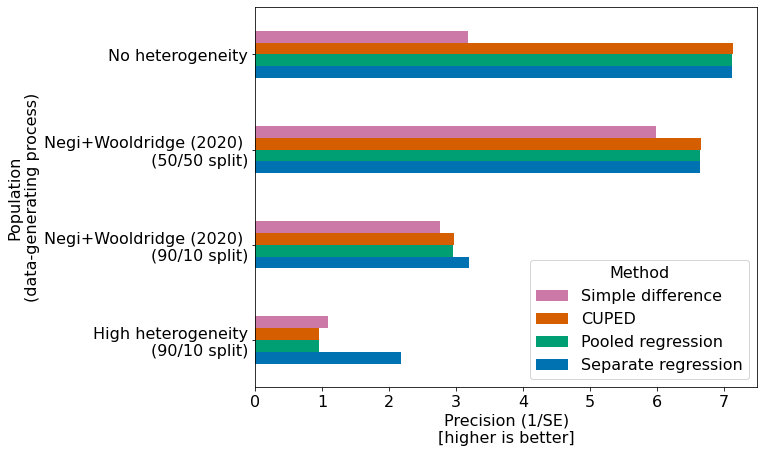

In [124]:
# Make a graph of the precision for each (population, estimator)
precision = (1 / dx.groupby('population').std())
precision = precision.loc[
                          ['challenge', 'negi_wooldridge_2020_low_10', 'negi_wooldridge_2020_low', 'basic'],
                          ['fra', 'pra', 'cuped', 'sm']
                          ]
precision = precision.rename(
    index={
        'basic': 'No heterogeneity',
        'negi_wooldridge_2020_low': 'Negi+Wooldridge (2020) \n (50/50 split)',
        'negi_wooldridge_2020_low_10': 'Negi+Wooldridge (2020) \n(90/10 split)',
        'challenge': 'High heterogeneity\n(90/10 split)'
        },
    columns={
    'fra': 'Separate regression',
     'cuped': 'CUPED',
      'pra': 'Pooled regression',
      'sm': 'Simple difference'
      })

with plt.style.context('seaborn-colorblind'):
  plt.rcParams['font.size'] = '16'
  ax = precision.plot.barh(figsize=(9, 7))
  ax.set_xlabel("Precision (1/SE)\n[higher is better]")
  ax.set_ylabel("Population\n(data-generating process)")
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(reversed(handles), reversed(labels), title='Method')